<div style="border-radius:10px;
            border:#0b0265 solid;
           background-color:#cc6699;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><h1 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Neural Style Transfer </h1></center>    

</div>

# Imports

In [5]:
import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from pathlib import Path

In [6]:
# path to the content and the style image

content_path = Path('/content/indoor-picture-cheerful-handsome-young-man-having-folded-hands-looking-directly-smiling-sincerely-wearing-casual-clothes.jpg')
style_path = Path('/content/1435.jpg')

In [9]:
# here we are import reshaping the image and making suitable to input to the model
def load_img(path_to_img):

  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

def load_images(content_path, style_path):
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image

# here we are dislaying the images
def imshow(image, title=None):

  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)

def show_images_with_objects(images, titles=[]):
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)

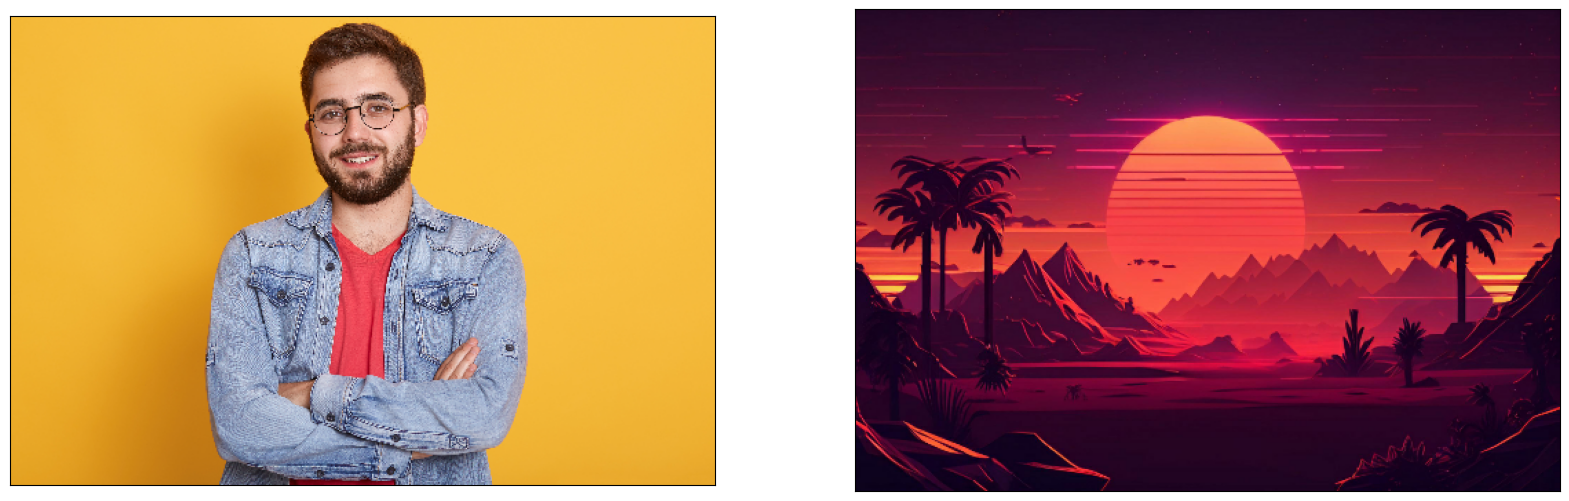

In [10]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image],
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

# Build the feature extractor

We will inspect the layers of the Inception model.

In [11]:
# clear session to make layer naming consistent when re-running this cell, this is necessary as we will be using the layer to extract features
# from the inception network. In most of the literature or example, VGG19 is used, reason being it is very deep and is able to extract features
# nicely. Same is the case with the inception network.
K.clear_session()


tmp_inception = tf.keras.applications.InceptionV3()
tmp_inception.summary()
del tmp_inception

96112376/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

As you can see, it's a very deep network and compared to VGG-19, it's harder to choose which layers to choose to extract features from.

Notice that the Conv2D layers are named from conv2d, conv2d_1 ... conv2d_93, for a total of 94 conv2d layers.
So the second conv2D layer is named conv2d_1.

We choose the following:

* For the content layer: the Conv2D layer indexed at 88.
* For the style layers: the first five conv2D layers near the input end of the model.

In [12]:
# choosing the content layer, a lower layer is to be choosen, as lower layer has a high degree of content, while upper layer have
# high degree of style information, like edges.
content_layers = ['conv2d_93']


style_layers = ['conv2d',
                'conv2d_1',
                'conv2d_2',
                'conv2d_3',
                'conv2d_4']

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

We can now setup our model to output the selected layers.

In [13]:
def inception_model(layer_names):

  inception = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights= 'imagenet')
  inception.trainable = False

  output_layers = [inception.get_layer(name).output for name in layer_names]

  model = tf.keras.models.Model(inputs = inception.input, outputs = output_layers)

  return model

Create an instance of the content and style model using the function that you just defined

In [14]:
K.clear_session()

# loading the inception net with all the layers and their respective weight
inception = inception_model(content_and_style_layers)
inception

87910968/87910968 [==============================] - 0s 0us/step


# Calculate style loss

The style loss is the average of the squared differences between the features and targets.

In [15]:
def get_style_loss(features, targets):
  style_loss =  tf.reduce_mean(tf.square(features - targets))

  return style_loss

# Calculate content loss

Calculate the sum of the squared error between the features and targets, then multiply by a scaling factor (0.5).

In [16]:
def get_content_loss(features, targets):
  # get the sum of the squared error multiplied by a scaling factor
  content_loss =  0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

# Calculate the gram matrix

In [17]:
# gram matrix is the similarity matrix, it contains degree of the siilarity between feature.

def gram_matrix(input_tensor):

  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)


  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]


  num_locations = tf.cast(height * width, tf.float32)


  scaled_gram = gram / num_locations

  return scaled_gram

# Get the style image features

Given the style image as input, you'll get the style features of the inception model that you just created using inception_model().

We'll first preprocess the image using the preprocess_image function.

We'll then get the outputs of the model.

From the outputs, we just get the style feature layers and not the content feature layer.

In [18]:
tmp_layer_list = [layer.output for layer in inception.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32

For each style layer, calculate the gram matrix. Store these results in a list and return it.

In [19]:
# normalizing and clipping the image
def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

In [20]:
def get_style_image_features(image):

  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # get the outputs from the inception model that you created using inception_model()
  outputs = inception(preprocessed_style_image)

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

# Get content image features

In [21]:
def get_content_image_features(image):
  """ Get the content image features

  Args:
    image: an input image

  Returns:
    content_outputs: the content features of the image
  """
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)

  # get the outputs from the inception model
  outputs = inception(preprocessed_content_image)

  # get the content layer of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

# Calculate the total loss

$L_{total} = \beta L_{style} + \alpha L_{content}$

In [22]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):

  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss =  style_loss * style_weight / NUM_STYLE_LAYERS

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS

  # sum up the style and content losses
  total_loss = style_loss + content_loss

  # return the total loss
  return total_loss

# Calculate gradients

We use tf.GradientTape() to get the gradients of the loss with respect to the input image.

In [23]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight):

  with tf.GradientTape() as tape:

    # get the style image features
    style_features = get_style_image_features(image)

    # get the content image features
    content_features = get_content_image_features(image)

    # get the style and content loss
    loss =  get_style_content_loss(style_targets, style_features, content_targets,
                                  content_features, style_weight, content_weight)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  return gradients

# Update the image with the style

In [24]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

In [25]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
  """
  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets,
                                  style_weight, content_weight)

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])

  # Clip the image using the given clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

# Generate the stylized image

In [26]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)

In [27]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch

  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch
  """
  images = []
  step = 0

  # get the style image features
  style_targets = get_style_image_features(style_image)

  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  # collect the image updates starting from the content image
  images.append(content_image)

  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1

      # Update the image with the style using the function that we defined
      update_image_with_style(generated_image, style_targets, content_targets,
                              style_weight, content_weight, optimizer)

      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)

    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))

  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

With all the functions defined, we can now run the main loop and generate the stylized image.

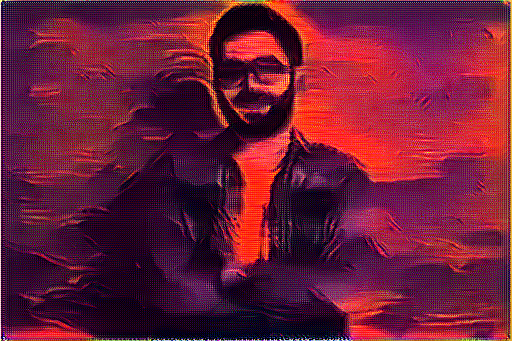

Train step: 1000


In [28]:
# define style and content weight
style_weight =  0.35
content_weight = 1e-32

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

With Lower style weight

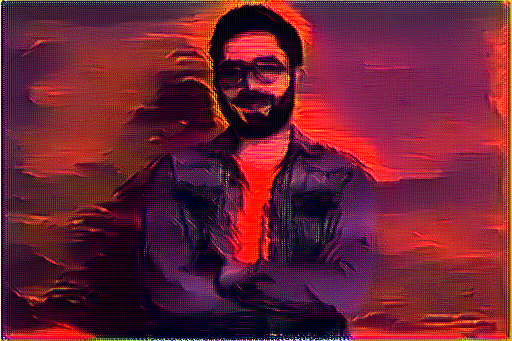

Train step: 1000


In [30]:
# define style and content weight
style_weight =  0.2
content_weight = 1e-32

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

If you want to try different images, you may need to change the content and style weight for better results (specially the style weight.)